# Image Segmentation

* Reference link : https://www.tensorflow.org/tutorials/images/segmentation?hl=ko
* 목적 : 관심 분야인 Image Segmentation에 대한 예제를 보면서 구현하여 과정을 익힌다.
* Framework : Tensorflow 2
* Dataset : Oxford-IIIT Pet Dataset
* 코드 link와 동일하기 때문에 공부하려면 위 링크 타고 공부하면 됩니다.

## Image Segmentation이란?

이미지에서 개체가 가지는 위치와 그 모양, 또는 어떤 픽셀이 어떤 모양에 속하는지 알기 위해 이미지를 분할한다. 본 task는 multi-output Classification에 속하며, 즉 각 픽셀에 레이블이 부여된다. Image segmentation task에서는 픽셀 단위의 마스크를 출력하도록 신경망을 훈련시키며 픽셀 레벨에서 이미지를 이해하는 데 도움이 된다.

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [4]:
import tensorflow as tf

In [5]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download Dataset

Oxford-IIT Pets 데이터셋은 이미 텐서플로 데이터 세트에 포함되어 있어 다운만 하면 되며, segmentation mask는 버전 3+에 포함되어 있음

In [6]:
# Download dataset

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\202132045\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [7]:
# Normalize pixel
## tf.cast : change datatype of data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1 # origin label [1, 2, 3] -> [0, 1, 2]
    return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
    # Resize data to (128, 128)
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    # 각 배치 당 50%의 확률로 데이터 좌우 플립
    if tf.random.uniform(()) > 0.5: 
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    # Normalize
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [10]:
# Test data에는 flip 과정이 필요없음

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples # 훈련세트의 개수
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
# batch의 개수 : 전체 훈련세트의 개수 / 배치 사이즈

In [12]:
# train, test 데이터셋 전처리
## tf.data.experimental.AUTOTUNE : 동적으로 적절한 스레드 수 설정
## map : instance wise 변환

train = dataset['train'].map(load_image_train,
                             num_parallel_calls = tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [13]:
# train, test 데이터셋 선언 : 데이터 셔플 및 배치
## prefetch : data 훈련 중 입력 파이프라인이 다음 데이터를 읽어옴
### 여기서 AUTOTUNE은 data 런타임이 실행 시 동적으로 값을 조정하는 역할
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [17]:
# Display function

def display(display_list):
    plt.figure(figsize=(15, 15)) # image size를 (15, 15)로 resize
    
    # 볼 수 있는 데이터는 세 가지 : input img, label mask, 예측 mask
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) #(1, len(display_list)) 형태의 plot
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

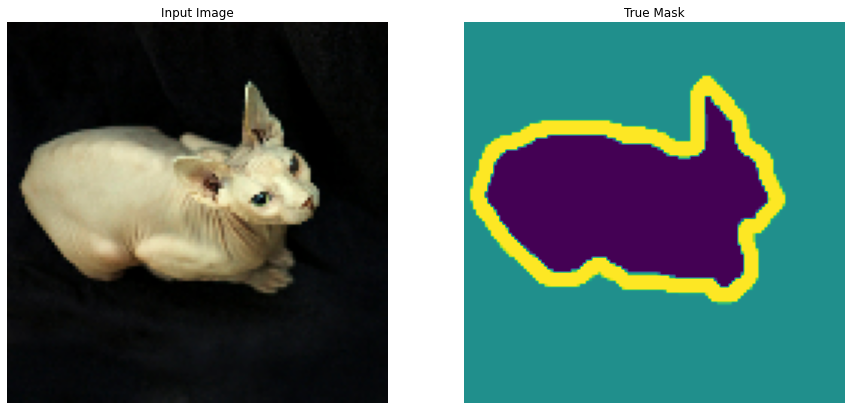

In [18]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 모델 정의하기

본 코드에서 사용하는 모델은 'modified U-Net(mU-Net)'으로, 인코더와 디코더를 포함한다.
본 모델은 pre-trained된 모델을 인코더로 사용할 수 있으며, 따라서 인코더로 pre-trained MobileNetV2를, 디코더로는 Pix2pix를 사용한다. <br>
한 편, oxford data segmentation set은 총 세개의 class가 존재하는데, 이는 다음과 같다.<br>
* class 1 : 애완동물이 속한 픽셀
* class 2 : 애완동물과 인접한 픽셀
* class 3 : 위 두 경우에 속하지 않는 픽셀/배경 픽셀
<br>

따라서 본 문제는 3-class classification이라고 생각해도 된다.

In [19]:
# Class 개수 : 3
OUTPUT_CHANNELS = 3

In [20]:
# Pretrained MobileNetV2를 이용, 인코더는 모델의 중간 hidden layer의 출력으로 구성됨
base_model = tf.keras.applications.MobileNetV2(input_shape = [128, 128, 3],
                                              include_top = False)

# 출력값으로 사용할 layer
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징(embedding) 추출 모델 제작
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False # 인코더는 train 도중 파라미터가 변하면 안됨

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
# Pix2pix의 업샘플링 function 사용, 채널이 이미지가 감소하는 만큼 증가함을 알 수 있음

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3]) # dim : 128*128*3(RGB)
    x = inputs
    
    # Downsampling, 'skips'는 skip-connection을 위해 쓰이는 레이어의 출력들을 의미
    ## Downsampling에 쓰인 기술들은 논문 봐야할 듯
    skips = down_stack(x)
    x = skips[-1] # output layer의 결과물은 upsampling하는데 쓰임
    # output layer의 결과를 제외한 나머지 output을 거꾸로 뒤집어야 concat이 가능
    skips = reversed(skips[:-1]) 
   
    
    # Upsampling skip-connected output
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    # Last layer : De-convolution(Transpose conv)
    ## resize to 2x and transform channel to 3
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

## 모델 훈련하기

모델 훈련 과정에서는 손실함수를 설정하고 여러 hyperparameter를 설정함

In [23]:
# 모델 로드 및 컴파일
## optimizer : adam
## loss : SparseCategoricalCrossentropy, 멀티 클래스 예측이라 생각해도 되서 그럼
### from_logits=True : classification 결과물이 확률이다(or softmax layer 포함되어있다)
## metrics : acc (classification task라)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer = 'adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
        

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [31]:
# 훈련하지 않은 상태에서의 예측 마스크를 그려보기

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) # axis가 채널축?
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [32]:
# display 함수

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
          pred_mask = model.predict(image)
          display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

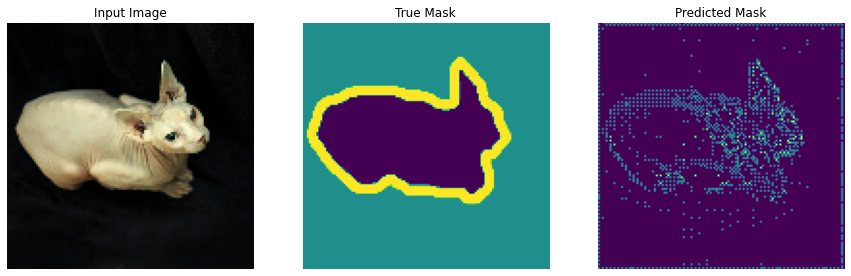

In [33]:
show_predictions()

In [34]:
# callback 이후 prediction을 보기 위한 class 설정

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

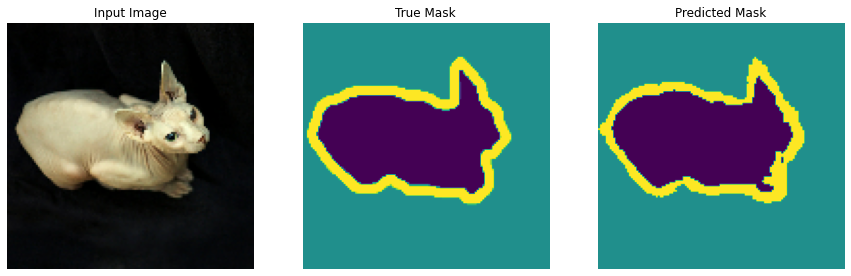


에포크 이후 예측 예시 20

57/57 [==============================] - 6s 103ms/step - loss: 0.1332 - accuracy: 0.9391 - val_loss: 0.3277 - val_accuracy: 0.8874


In [35]:
# model train
## DisplayCallback class로 에폭이 지날때마다 모델이 어떻게 개선되는지 볼 수 있음(신기쓰)
## epochs = 20, val_subsplits = 5로 배치마다 5분의 1은 validataion data

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

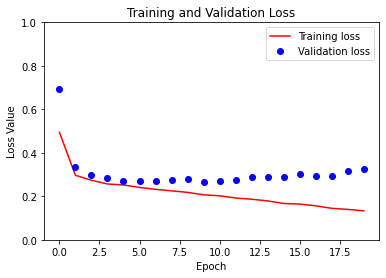

In [36]:
# loss 및 training loss
## 대략 8 epoch부터 val loss가 상승함 

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

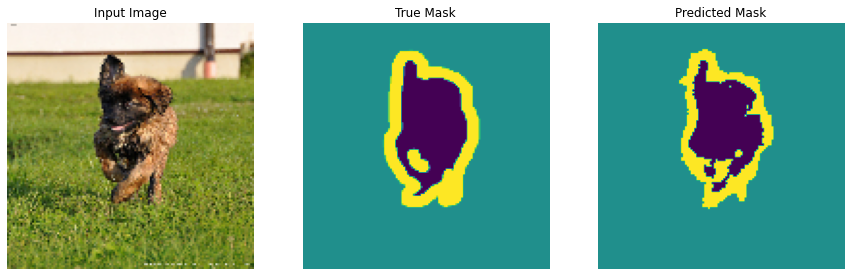

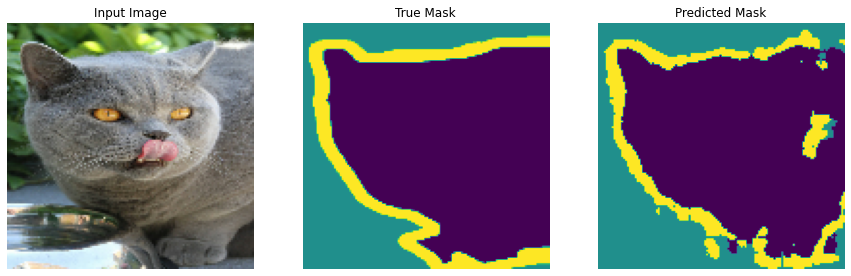

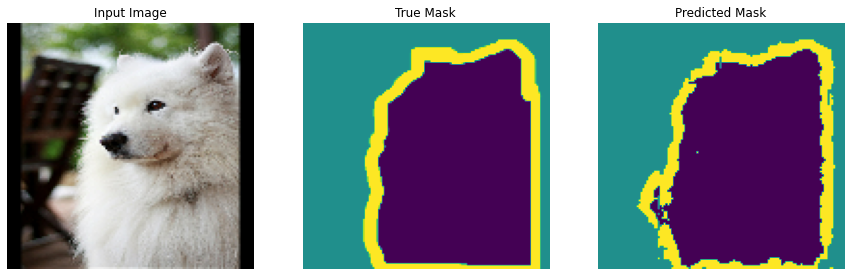

In [37]:
# 마지막으로 직접 예측결과를 보기
## 예측이 완벽하게 이뤄졌다고 보기는 어려움

show_predictions(test_dataset, 3)